<a href="https://colab.research.google.com/github/sudarshanmungi39/Generative-modelling-case-study-Cyber-Security-/blob/main/research_assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Building and Understanding GANs from Scratch

In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import numpy as np

# Set seed for reproducibility
torch.manual_seed(42);

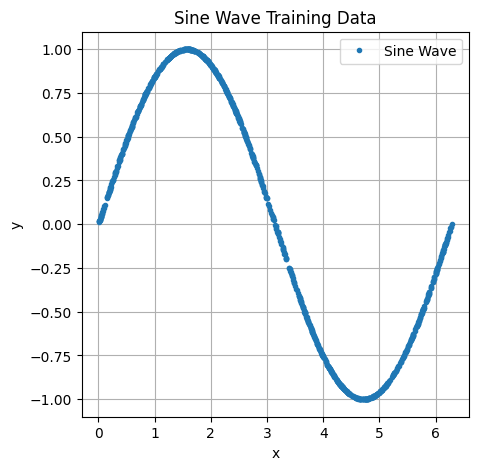

In [ ]:
# Generate sine-wave data for Task 1
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = 2.0 * math.pi * torch.rand(train_data_length)  # x ~ U(0, 2π)
train_data[:, 1] = torch.sin(train_data[:, 0])  # y = sin(x)
train_labels = torch.zeros(train_data_length)

train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Plot sine-wave training data
plt.figure(figsize=(5, 5))
plt.plot(train_data[:, 0], train_data[:, 1], ".", label="Sine Wave")
plt.title("Sine Wave Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

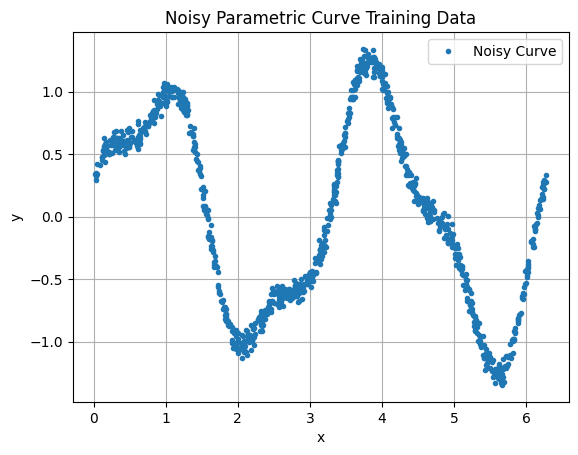

In [ ]:
# Create 2D data for the noisy parametric curve
train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))

# Generate random x values in [0, 2π]
train_data[:, 0] = 2.0 * math.pi * torch.rand(train_data_length)

# Compute y = sin(2x) + 0.3cos(5x) + noise
noise = 0.05 * torch.randn(train_data_length)
train_data[:, 1] = torch.sin(2 * train_data[:, 0]) + 0.3 * torch.cos(5 * train_data[:, 0]) + noise

# Dummy labels (not used in GAN)
train_labels = torch.zeros(train_data_length)
train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

# Plot to verify
plt.plot(train_data[:, 0], train_data[:, 1], ".", label="Noisy Curve")
plt.title("Noisy Parametric Curve Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define the Discriminator(Relu)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

discriminator = Discriminator()

In [ ]:
# Define the Generator (Relu)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        return self.model(x)

generator = Generator()

In [ ]:
# Set Up Training Configaration (loss, optimizer, epochs)

lr = 0.001
num_epochs = 3000  # Increased for better convergence
loss_function = nn.BCELoss()

optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = optim.Adam(generator.parameters(), lr=lr)

In [ ]:
# GAN Training Loop

losses_g = []
losses_d = []

for epoch in range(num_epochs):
    for real_samples, _ in train_loader:
        real_samples = real_samples.float()

        # === Train Discriminator ===
        real_labels = torch.ones((real_samples.size(0), 1))
        fake_labels = torch.zeros((real_samples.size(0), 1))

        # Generate fake samples
        latent_space_samples = torch.randn(real_samples.size(0), 2)
        generated_samples = generator(latent_space_samples)

        # Combine real and fake
        all_samples = torch.cat((real_samples, generated_samples), dim=0)
        all_labels = torch.cat((real_labels, fake_labels), dim=0)

        # Train discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_d = loss_function(output_discriminator, all_labels)
        loss_d.backward()
        optimizer_discriminator.step()

        # === Train Generator ===
        generator.zero_grad()
        latent_space_samples = torch.randn(real_samples.size(0), 2)
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)

        loss_g = loss_function(output_discriminator_generated, real_labels)
        loss_g.backward()
        optimizer_generator.step()

    # Save losses for plotting
    losses_d.append(loss_d.item())
    losses_g.append(loss_g.item())

    # Print every 500 epochs for feedback
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss D = {loss_d.item():.4f} | Loss G = {loss_g.item():.4f}")

Epoch 0: Loss D = 0.1099 | Loss G = 2.6297
Epoch 500: Loss D = 0.6824 | Loss G = 0.7748
Epoch 1000: Loss D = 0.6312 | Loss G = 0.7489
Epoch 1500: Loss D = 0.6851 | Loss G = 0.7481
Epoch 2000: Loss D = 0.6977 | Loss G = 0.7130
Epoch 2500: Loss D = 0.6786 | Loss G = 0.7272


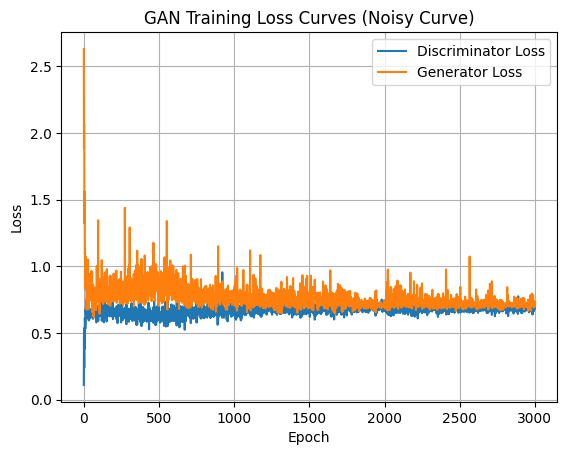

In [ ]:
# Plot Training Loss curves

plt.plot(losses_d, label="Discriminator Loss")
plt.plot(losses_g, label="Generator Loss")
plt.title("GAN Training Loss Curves (Noisy Curve)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

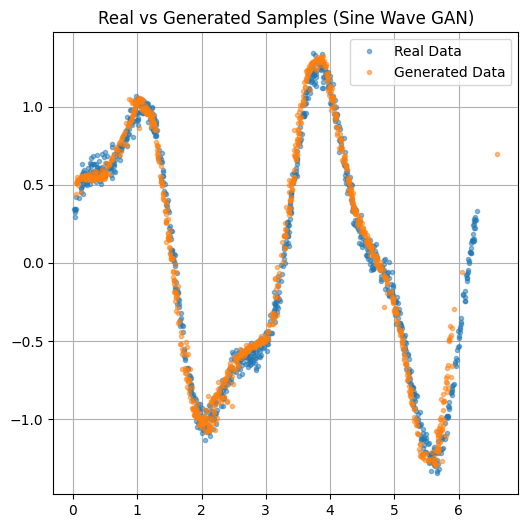

In [ ]:
# Plot real vs generated data samples
# Generate and Plot Fake Data

# Generate new samples from the generator
latent_samples = torch.randn(1000, 2)
generated = generator(latent_samples).detach().numpy()

plt.figure(figsize=(6, 6))
plt.plot(train_data[:, 0], train_data[:, 1], ".", label="Real Data", alpha=0.5)
plt.plot(generated[:, 0], generated[:, 1], ".", label="Generated Data", alpha=0.5)
plt.title("Real vs Generated Samples (Sine Wave GAN)")
plt.legend()
plt.grid(True)
plt.show()

## Task 3: Modified GAN Architecture Using LeakyReLU

In [ ]:
# Modified Generator (LeakyRelu)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        # Define a deeper MLP generator using LeakyReLU
        self.model = nn.Sequential(
            nn.Linear(2, 64),           # Input layer: from 2D latent space to 64 neurons
            nn.LeakyReLU(0.2),          # LeakyReLU helps avoid dead neurons
            nn.Linear(64, 128),         # Hidden layer: deeper architecture improves expressiveness
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),         # Hidden layer: added depth allows better function approximation
            nn.LeakyReLU(0.2),
            nn.Linear(64, 2)            # Output layer: generates 2D points
        )

    def forward(self, x):
        return self.model(x)  # Forward pass through the generator

In [ ]:
# Modified Discriminator (LeakyRelu)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # A slightly shallower discriminator using LeakyReLU and dropout for regularization
        self.model = nn.Sequential(
            nn.Linear(2, 64),           # Input layer: accepts 2D samples
            nn.LeakyReLU(0.2),          # LeakyReLU improves gradient flow
            nn.Dropout(0.3),            # Dropout prevents overfitting
            nn.Linear(64, 32),          # Reduced complexity to balance generator
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(32, 1),           # Output layer: single value (real/fake probability)
            nn.Sigmoid()                # Sigmoid activation to squash output to [0, 1]
        )

    def forward(self, x):
        return self.model(x)  # Forward pass through the discriminator

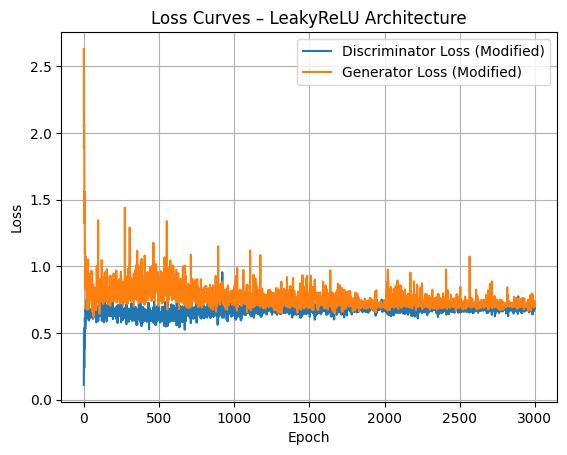

In [ ]:
# Plot training loss curves

plt.plot(losses_d, label="Discriminator Loss (Modified)")
plt.plot(losses_g, label="Generator Loss (Modified)")
plt.title("Loss Curves – LeakyReLU Architecture")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

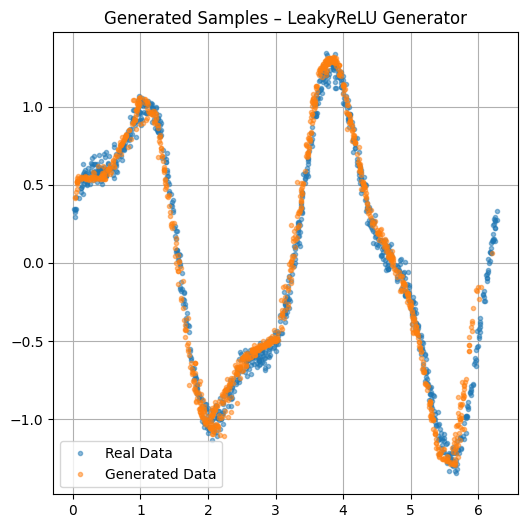

In [ ]:
# Plot real vs generated data samples

latent_samples = torch.randn(1000, 2)
generated = generator(latent_samples).detach().numpy()

plt.figure(figsize=(6, 6))
plt.plot(train_data[:, 0], train_data[:, 1], ".", label="Real Data", alpha=0.5)
plt.plot(generated[:, 0], generated[:, 1], ".", label="Generated Data", alpha=0.5)
plt.title("Generated Samples – LeakyReLU Generator")
plt.legend()
plt.grid(True)
plt.show()

## Summary
All tasks from Part 1 were completed:
- Task 1: Baseline sine wave GAN
- Task 2: Noisy parametric function modeled
- Task 3: LeakyReLU-based model showed improved stability and sharper outputs
Ready for Part 2: Cybersecurity GAN (CICIDS 2017).

## Part 2 - Cybersecurity – Synthetic Traffic with CICIDS 2017

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

folder_path = "/content/drive/MyDrive/CICIDS2017"  # adjust if needed
print("Files found in folder:")
print(os.listdir(folder_path))

Files found in folder:
['research assignment 2.ipynb', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv.zip', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv.zip', 'Friday-WorkingHours-Morning.pcap_ISCX.csv.zip', 'Monday-WorkingHours.pcap_ISCX.csv.zip', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv.zip', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip', 'Tuesday-WorkingHours.pcap_ISCX.csv.zip', 'Wednesday-workingHours.pcap_ISCX.csv.zip', 'Wednesday-workingHours.pcap_ISCX.csv', 'Tuesday-WorkingHours.pcap_ISCX.csv', 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 'Monday-WorkingHours.pcap_ISCX.csv', 'Friday-WorkingHours-Morning.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv']


In [ ]:
import zipfile
import os

folder_path = "/content/drive/MyDrive/CICIDS2017"
zip_files = [f for f in os.listdir(folder_path) if f.endswith(".zip")]

for zip_file in zip_files:
    zip_path = os.path.join(folder_path, zip_file)
    output_path = os.path.join(folder_path, zip_file.replace(".zip", ""))
    if not os.path.exists(output_path):  # avoid extracting again
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        print(f" Extracted: {zip_file}")
    else:
        print(f" Already extracted: {zip_file}")

 Already extracted: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv.zip
 Already extracted: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv.zip
 Already extracted: Friday-WorkingHours-Morning.pcap_ISCX.csv.zip
 Already extracted: Monday-WorkingHours.pcap_ISCX.csv.zip
 Already extracted: Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv.zip
 Already extracted: Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip
 Already extracted: Tuesday-WorkingHours.pcap_ISCX.csv.zip
 Already extracted: Wednesday-workingHours.pcap_ISCX.csv.zip


 Loaded: Monday-WorkingHours.pcap_ISCX.csv
 Loaded: Tuesday-WorkingHours.pcap_ISCX.csv
 Loaded: Wednesday-workingHours.pcap_ISCX.csv
 Missing: Thursday-workingHours-Morning-WebAttacks.pcap_ISCX.csv
 Missing: Thursday-workingHours-Afternoon-Infilteration.pcap_ISCX.csv
 Loaded: Friday-WorkingHours-Morning.pcap_ISCX.csv
 Loaded: Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
 Loaded: Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
 Combined shape: (2371775, 80)


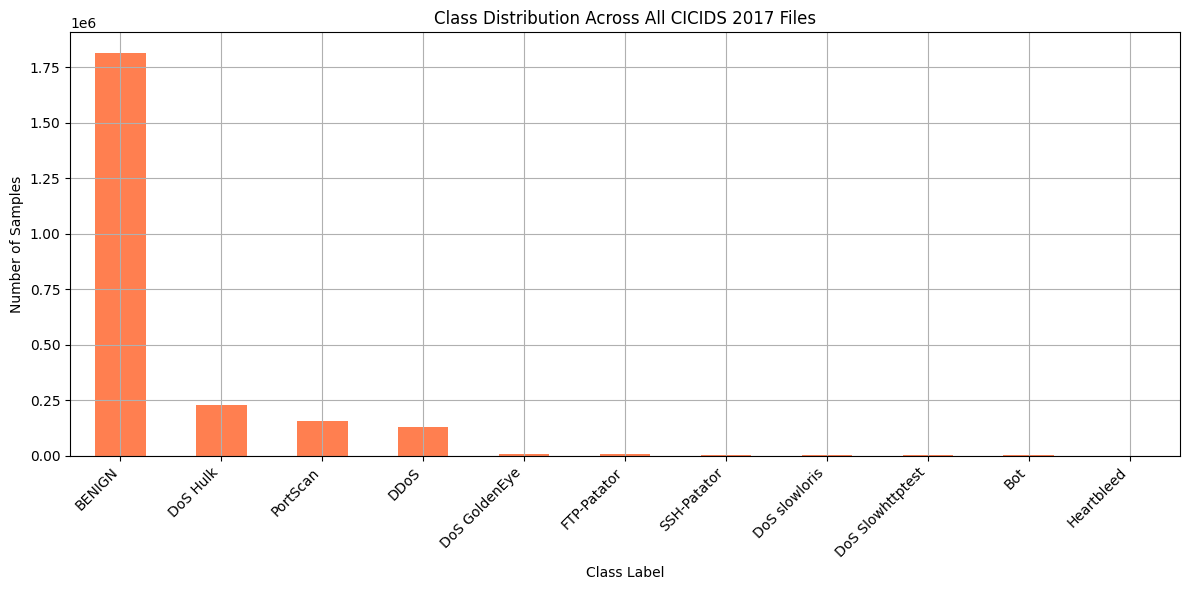

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

folder_path = "/content/drive/MyDrive/CICIDS2017"

# List of CSVs now unzipped and ready
filenames = [
    "Monday-WorkingHours.pcap_ISCX.csv",
    "Tuesday-WorkingHours.pcap_ISCX.csv",
    "Wednesday-workingHours.pcap_ISCX.csv",
    "Thursday-workingHours-Morning-WebAttacks.pcap_ISCX.csv",
    "Thursday-workingHours-Afternoon-Infilteration.pcap_ISCX.csv",
    "Friday-WorkingHours-Morning.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
]

dataframes = []
for file in filenames:
    file_path = os.path.join(folder_path, file)
    if os.path.exists(file_path):
        print(f" Loaded: {file}")
        df = pd.read_csv(file_path, low_memory=False)
        df["SourceFile"] = file
        dataframes.append(df)
    else:
        print(f" Missing: {file}")

# Combine the DataFrames
df_all = pd.concat(dataframes, ignore_index=True)
df_all.columns = df_all.columns.str.strip()  # Remove leading/trailing spaces from column names
print(" Combined shape:", df_all.shape)

# Plot class balance
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
df_all['Label'].value_counts().head(20).plot(kind='bar', color='coral')
plt.title("Class Distribution Across All CICIDS 2017 Files")
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn

# Define the Generator
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=78):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim=78):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Instantiate
generator = Generator()
discriminator = Discriminator()

print(generator)
print(discriminator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=78, bias=True)
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=78, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [ ]:
import numpy as np            # Import NumPy for handling NaNs/Infs

# Load only the Wednesday file (again, cleanly)
wednesday_path = os.path.join(folder_path, "Wednesday-workingHours.pcap_ISCX.csv")
df_wed = pd.read_csv(wednesday_path, low_memory=False)
df_wed.columns = df_wed.columns.str.strip()  # remove whitespace from headers
print(" Wednesday data shape:", df_wed.shape)

# Filter for only BENIGN and DoS Hulk labels
df_filtered = df_wed[df_wed['Label'].isin(['BENIGN', 'DoS Hulk'])]
print(" Filtered BENIGN + DoS Hulk shape:", df_filtered.shape)

# Drop string/object columns
non_numeric_cols = df_filtered.select_dtypes(include='object').columns
cols_to_drop = [col for col in non_numeric_cols if col not in ['Label']]
df_filtered = df_filtered.drop(columns=cols_to_drop)
print(" Dropped non-numeric cols:", cols_to_drop)

# Remove rows with NaN or Inf
df_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)
df_filtered.dropna(inplace=True)
print(" After removing NaNs/Infs:", df_filtered.shape)

# Separate features and labels (we only need features for GAN)
features = df_filtered.drop(columns=['Label'])

# Normalize the features using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Convert to PyTorch tensor
features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
print(" Final tensor shape for GAN training:", features_tensor.shape)

 Wednesday data shape: (692703, 79)
 Filtered BENIGN + DoS Hulk shape: (671104, 79)
 Dropped non-numeric cols: []
 After removing NaNs/Infs: (669807, 79)
 Final tensor shape for GAN training: torch.Size([669807, 78])


In [ ]:
# GAN Training

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader for real samples
batch_size = 128
real_dataset = TensorDataset(features_tensor)
real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True)

# Set up loss and optimizers
loss_function = nn.BCELoss()
lr = 0.0002
optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr)

In [ ]:
# Training loop

import matplotlib.pyplot as plt

# Number of epochs
num_epochs = 100

# For tracking losses
losses_g = []
losses_d = []

for epoch in range(num_epochs):
    for real_batch in real_loader:
        real_samples = real_batch[0]

        # === Train Discriminator ===
        real_labels = torch.ones((real_samples.size(0), 1))
        fake_labels = torch.zeros((real_samples.size(0), 1))

        # Generate fake samples
        latent_vectors = torch.randn(real_samples.size(0), 100)
        fake_samples = generator(latent_vectors)

        # Discriminator loss on real and fake
        discriminator.zero_grad()
        d_real = discriminator(real_samples)
        d_fake = discriminator(fake_samples.detach())
        loss_d = loss_function(d_real, real_labels) + loss_function(d_fake, fake_labels)
        loss_d.backward()
        optimizer_d.step()

        # === Train Generator ===
        generator.zero_grad()
        d_fake_for_g = discriminator(fake_samples)
        loss_g = loss_function(d_fake_for_g, real_labels)  # We want to fool the discriminator
        loss_g.backward()
        optimizer_g.step()

    # Save losses per epoch
    losses_d.append(loss_d.item())
    losses_g.append(loss_g.item())

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss D = {loss_d.item():.4f} | Loss G = {loss_g.item():.4f}")

Epoch 0: Loss D = 0.9642 | Loss G = 1.4344
Epoch 10: Loss D = 1.2966 | Loss G = 1.0471
Epoch 20: Loss D = 1.1899 | Loss G = 0.9461
Epoch 30: Loss D = 1.1872 | Loss G = 0.8735
Epoch 40: Loss D = 1.1504 | Loss G = 0.8515
Epoch 50: Loss D = 1.2560 | Loss G = 0.9000
Epoch 60: Loss D = 1.2073 | Loss G = 0.9334
Epoch 70: Loss D = 1.1477 | Loss G = 1.0044
Epoch 80: Loss D = 1.1691 | Loss G = 1.1003
Epoch 90: Loss D = 2.6825 | Loss G = 2.4552


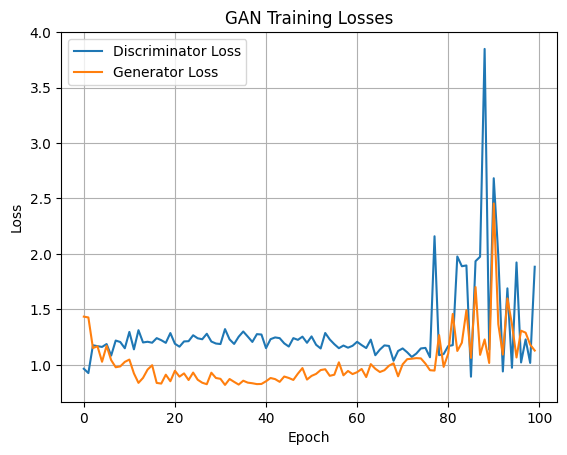

In [ ]:
# Plot Loss Curves

plt.plot(losses_d, label='Discriminator Loss')
plt.plot(losses_g, label='Generator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.grid(True)
plt.show()

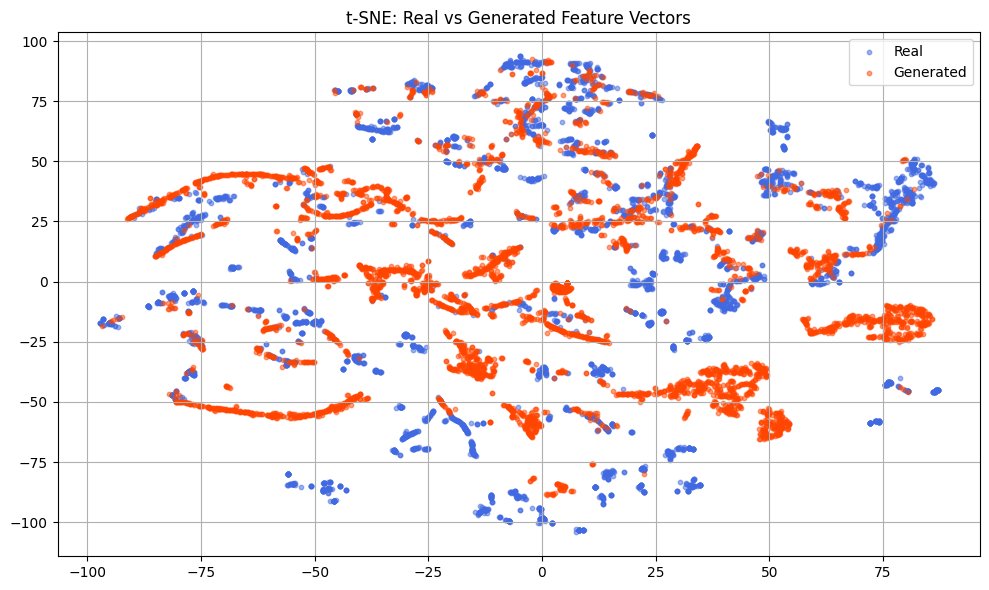

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

# Sample 5000 real feature vectors from your tensor
num_samples = 5000
real_subset = features_tensor[:num_samples].cpu().numpy()

# Generate 5000 synthetic samples from the generator
latent_dim = 100
noise = torch.randn(num_samples, latent_dim)
with torch.no_grad():
    fake_samples = generator(noise).cpu().numpy()

# Combine for t-SNE
combined = np.vstack([real_subset, fake_samples])
labels = np.array([0] * num_samples + [1] * num_samples)  # 0=real, 1=fake

# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(combined)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1],
            label="Real", alpha=0.5, s=10, c='royalblue')
plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1],
            label="Generated", alpha=0.5, s=10, c='orangered')
plt.title("t-SNE: Real vs Generated Feature Vectors")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.linalg import sqrtm
import numpy as np

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2):
    """Computes the Frechet Distance between two multivariate Gaussians."""
    covmean = sqrtm(sigma1 @ sigma2)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum((mu1 - mu2)**2) + np.trace(sigma1 + sigma2 - 2 * covmean)

# Generate 5000 synthetic samples
num_samples = 5000
latent_dim = 100

# Use same real tensor used for training
real_subset = features_tensor[:num_samples].detach().cpu().numpy()
noise = torch.randn(num_samples, latent_dim)
fake_subset = generator(noise).detach().cpu().numpy()

# Calculate statistics
mu_real = real_subset.mean(axis=0)
sigma_real = np.cov(real_subset, rowvar=False)

mu_fake = fake_subset.mean(axis=0)
sigma_fake = np.cov(fake_subset, rowvar=False)

# Compute Frechet Distance
frechet_distance = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"Frechet Distance (FD) using 5000 samples: {frechet_distance:.4f}")

Frechet Distance (FD) using 5000 samples: 5.9188


/tmp/ipython-input-25-3496025909.py:6: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = sqrtm(sigma1 @ sigma2)


In [ ]:
# Ensure fake_samples is detached and converted to NumPy
if torch.is_tensor(fake_samples):
    fake_samples = fake_samples.detach().cpu().numpy()

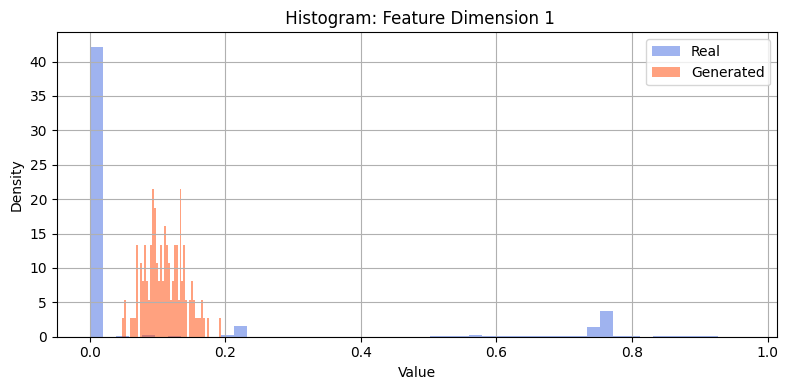

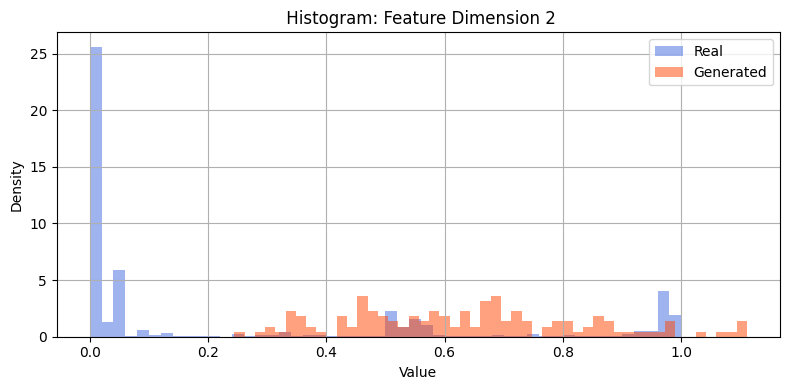

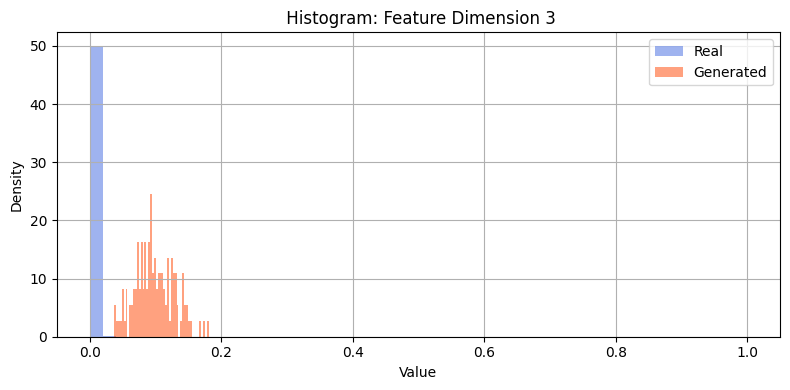

In [ ]:
import matplotlib.pyplot as plt

# Compare the first 3 feature dimensions
for i in range(3):
    plt.figure(figsize=(8, 4))
    plt.hist(real_subset[:, i], bins=50, alpha=0.5, label="Real", color='royalblue', density=True)
    plt.hist(fake_samples[:, i], bins=50, alpha=0.5, label="Generated", color='orangered', density=True)
    plt.title(f" Histogram: Feature Dimension {i+1}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()